In [1]:
import requests
import bs4
import re
import pandas as pd
import sqlite3
import time 
import random
import numpy as np 
import matplotlib.pyplot as plt
from scipy.special import expit

## Functions:

In [2]:
def get_ranks_series(race_rank_series):
    ranks = []
    for race_and_rank in race_rank_series:
        rank = re.search("\(((\d.\w+)|(\w\w)|(Olympics))\)$",race_and_rank)
        if rank != None:
            rank = rank.group(1)
            if rank not in ranks:
                ranks.append(rank)
        else:
            ranks.append(None)
    ranks = pd.Series(ranks)
    ranks.ffill(inplace=True)
    return ranks

def get_rider_stats (soup, rider_stats, race_ranks):
    rider_results_scrape = {"date": [],"result": [],"race_and_rank": [],"distance": [],"pcs": [],"uci": []}
    rider_results_key = list(rider_results.keys())

    for row in soup.find_all("tr")[:]:
        html_table_col = 0
        dict_key_loc = 0
        for col in row.find_all("td"):
            if not (col.has_attr('class') and col['class'][0] in ['season','ac',"bar"]):
                if html_table_col not in [2,3,8]:
                    col_value = col.text
                    if col_value=="":
                        ## add a None. We can clean the data after we extract it
                        rider_results_scrape[rider_results_key[dict_key_loc]].append(None)
                    else:
                        rider_results_scrape[rider_results_key[dict_key_loc]].append(col_value)
                    dict_key_loc = dict_key_loc + 1
                html_table_col = html_table_col + 1
            else:
                break

    df = pd.DataFrame(rider_results_scrape)
    df["result"] = pd.to_numeric(df["result"],errors="coerce").fillna(1000)
    df["distance"] = pd.to_numeric(df["distance"],errors="coerce").fillna(0)
    df["uci"] = pd.to_numeric(df["uci"],errors="coerce").fillna(0)    
    df["race_rank"] = get_ranks_series(df["race_and_rank"])

    rider_stats["tot_races"].append(len(df.loc[df["date"].notna()]))
    rider_stats["tot_distance"].append(df["distance"].sum())
    rider_stats["tot_wins"].append(len(df.loc[df["result"]==1]))
    rider_stats["tot_top_3"].append(len(df.loc[df["result"] <= 3]))
    rider_stats["tot_top_10"].append(len(df.loc[df["result"] <= 10]))
    rider_stats["tot_uci_points"].append(df["uci"].sum())

    for race_rank in race_ranks:
        race_rank_filter = df.loc[df["race_rank"] == race_rank]["uci"]
        rider_stats[race_rank+"_races"].append(len(race_rank_filter))
        rider_stats[race_rank+"_points"].append(sum(race_rank_filter))
    return rider_stats

def get_team_df(soup):
    teams = {"team" : [], "url" : [], "team_type" : []}
    found_alpecin = False
    
    for a in soup.select("a[href]"):
        href = a["href"]
        if ("team" in href and "2021" in href) and bool(a.find("img", recursive=False)) == False:
            if "alpecin" in href:
                found_alpecin = True
            teams["team"].append(a.text)
            teams["url"].append(href)
            if found_alpecin == True:
                teams["team_type"].append("PR")
            else:
                teams["team_type"].append("WT")
    return pd.DataFrame(teams)

def get_rider_stats_dict(race_ranks):
    rider_stats = {
        "name":[],
        "team":[],
        "tot_races":[],
        "tot_distance": [],
        "tot_uci_points":[],
        "tot_wins": [],
        "tot_top_3": [],
        "tot_top_10": [],
    }
    for race_rank in race_ranks:
        rider_stats[race_rank+"_races"] = []
        rider_stats[race_rank+"_points"] = []
        
    return rider_stats

def get_team_riders(soup):
    riders = []
    for div in soup.find_all('div', attrs={'class': "hide ttabs tabe"}):
        for li in div.find_all('li'):
            url = ""
            for a in li.find_all("a"):
                url = a["href"]
            rider = re.search(r"\D+\s[^(]*",li.text).group().strip()
            riders.append((rider, url))
    return riders

def find_all_rider_stat_points(lst):
    point_cols = []
    for col in lst:
        target_str_result = re.match("(^\d.\w+_points)", col)
        if target_str_result != None:
            point_cols.append(col)
    return point_cols

## Global Variables

In [505]:
BASE_URL = "https://www.procyclingstats.com/"

## Get and Clean the data
### First we will get the team DataFrame

In [506]:
all_teams_soup = bs4.BeautifulSoup(requests.get(BASE_URL+"teams.php?year=2021&filter=Filter").content)
teams_df = get_team_df(all_teams_soup)

In [507]:
teams_df["budget (in million euros)"] = None

In [508]:
teams_df.head(2)

,team,url,team_type,budget (in million euros)
0,AG2R Citroën Team,team/ag2r-citroen-team-2021,WT,None
1,Astana - Premier Tech,team/astana-premier-tech-2021,WT,None


### Team Budgets
#### For this section we will be using estimates for the budgets from the last few years. An assumption will be that the budgets have stayed constant

In [509]:
budgets = {
    'INEOS Grenadiers': 50.107,
    'Groupama - FDJ': 19.1,
    'Deceuninck - Quick Step': 19.1,
    'Lotto Soudal': 15.9,
    'AG2R Citroën Team': 23,
    'Cofidis':13,
    'Team Jumbo-Visma': 20 
}

for key, value in budgets.items():
    teams_df.loc[teams_df["team"] == key, "budget (in million euros)"] = value

### We will now get all the rider information for each WT team

In [511]:
wins = []
race_ranks = ['1.Pro', '2.Pro', '2.UWT', '1.1', '1.UWT', '2.1', 'Olympics', 'CC', 'WC']
rider_stats = get_rider_stats_dict(race_ranks)
wt_teams_df = teams_df.loc[((teams_df["team_type"] == "WT") & (teams_df["budget (in million euros)"].notna()))].copy()

for team, url in zip(wt_teams_df["team"], wt_teams_df["url"]):
    
    time.sleep(random.randint(2,5))
    team_soup = bs4.BeautifulSoup(requests.get(BASE_URL + url).content)
    
    team_wins = team_soup.find_all('ul', attrs={'class': "list horizontal teamkpi"})[0].find_all("a")[0].text
    wins.append(int(team_wins))
    
    riders = get_team_riders(team_soup)
    
    for rider in riders:
        
        time.sleep(random.randint(2,5))
        rider_stats["name"].append(rider[0])
        rider_stats["team"].append(team)
        rider_soup = bs4.BeautifulSoup(requests.get(BASE_URL + rider[1]).content)
        rider_stats = get_rider_stats(rider_soup, rider_stats, race_ranks)
        
rider_stats_df = pd.DataFrame(rider_stats)
wt_teams_df["wins"] = wins

## Backup the data in a SQLite DB

In [512]:
conn = sqlite3.connect("pro_cycling.db")
wt_teams_df.to_sql("world_tour_teams", conn, if_exists="replace")
rider_stats_df.to_sql("rider_stats", conn, if_exists="replace")
conn.close()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


## Access the data from the SQLite DB

In [3]:
conn = sqlite3.connect("pro_cycling.db")
wt_teams_df = pd.read_sql_query("SELECT * FROM world_tour_teams", conn)
rider_stats_df = pd.read_sql_query("SELECT * FROM rider_stats", conn)
conn.close()

In [4]:
wt_teams_df.drop(columns = "index", inplace = True)
rider_stats_df.drop(columns = "index", inplace = True)
rider_stats_df["team_member_agg"] = 1

In [5]:
wt_teams_df.head(2)

,team,url,team_type,budget (in million euros),wins
0,AG2R Citroën Team,team/ag2r-citroen-team-2021,WT,23,12
1,Cofidis,team/cofidis-2021,WT,13,12


In [6]:
rider_stats_df.head(2)

,name,team,tot_races,tot_distance,tot_uci_points,tot_wins,tot_top_3,tot_top_10,1.Pro_races,1.Pro_points,...,1.UWT_points,2.1_races,2.1_points,Olympics_races,Olympics_points,CC_races,CC_points,WC_races,WC_points,team_member_agg
0,O'CONNOR Ben,AG2R Citroën Team,77,10490.03,1227.0,1,3,17,1,0.0,...,76.0,12,53.0,0,0.0,0,0.0,0,0.0,1
1,COSNEFROY Benoît,AG2R Citroën Team,69,10685.24,1131.0,3,7,14,1,100.0,...,0.0,7,538.0,1,0.0,1,0.0,1,0.0,1


In [7]:
merge_df = pd.pivot_table(rider_stats_df, 
               index = "team", 
               values = find_all_rider_stat_points(list(rider_stats_df.columns[8:])),
               aggfunc = np.sum)
wt_teams_df = wt_teams_df.merge(merge_df, how="left", left_on = "team", right_on = merge_df.index)

In [31]:
wt_teams_df["scaled_budget"] = wt_teams_df["budget (in million euros)"].astype(float) * 1000000
wt_teams_df["total_team_points"] = wt_teams_df["1.1_points"] + wt_teams_df["1.Pro_points"] + wt_teams_df["1.UWT_points"] + wt_teams_df["2.1_points"] + wt_teams_df["2.Pro_points"] + wt_teams_df["2.UWT_points"]
wt_teams_df["point/euro"] = wt_teams_df["total_team_points"]/wt_teams_df["scaled_budget"]
wt_teams_df["wins/euro"] = wt_teams_df["wins"]/wt_teams_df["scaled_budget"]

In [11]:
wt_teams_df.head(10)

,team,url,team_type,budget (in million euros),wins,1.1_points,1.Pro_points,1.UWT_points,2.1_points,2.Pro_points,2.UWT_points,scaled_budget,total_team_points,point/euro
0,AG2R Citroën Team,team/ag2r-citroen-team-2021,WT,23,12,1414.0,306.00,471.00,1324.0,620.00,1930.00,23000000.0,6065.00,0.000264
1,Cofidis,team/cofidis-2021,WT,13,12,391.0,261.00,762.00,626.0,270.00,1703.00,13000000.0,4013.00,0.000309
2,Deceuninck - Quick Step,team/deceuninck-quick-step-2021,WT,19.1,65,490.0,1457.33,1583.00,891.6,2973.02,5291.00,19100000.0,12685.95,0.000664
3,Groupama - FDJ,team/groupama-fdj-2021,WT,19.1,22,431.0,377.00,343.00,766.0,1464.00,1488.00,19100000.0,4869.00,0.000255
4,INEOS Grenadiers,team/ineos-grenadiers-2021,WT,50.107,35,16.0,1101.00,2490.33,1488.0,640.32,3858.00,50107000.0,9593.65,0.000191
5,Lotto Soudal,team/lotto-soudal-2021,WT,15.9,12,1060.0,407.00,1044.00,443.0,777.00,642.00,15900000.0,4373.00,0.000275
6,Team Jumbo-Visma,team/team-jumbo-visma-2021,WT,20,43,88.0,2339.00,564.00,632.0,1433.33,5547.33,20000000.0,10603.66,0.000530


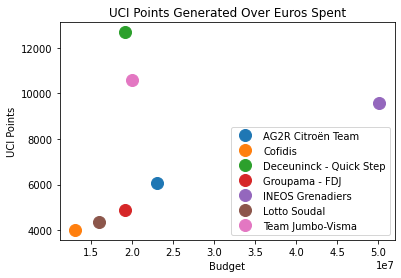

In [12]:
for budget, points, team in zip(wt_teams_df["scaled_budget"],wt_teams_df["total_team_points"],wt_teams_df["team"]):
    plt.plot(budget, points, marker='o', linestyle='', markersize=12, label=team)
plt.xlabel("Budget")
plt.ylabel("UCI Points")
plt.title("UCI Points Generated Over Euros Spent")
plt.legend()
plt.show()

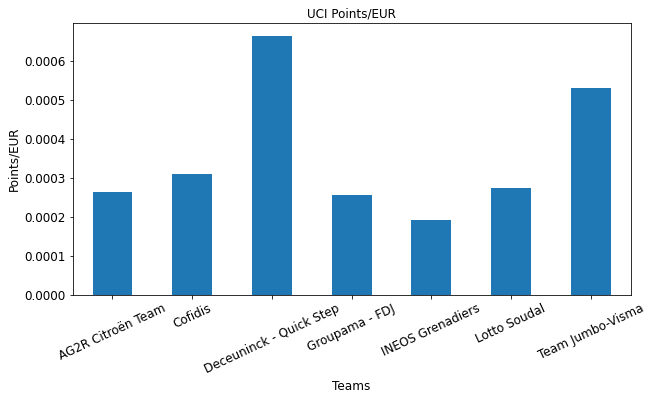

In [30]:
ax = wt_teams_df[["point/euro"]].plot(kind='bar', title ="UCI Points/EUR", figsize=(10, 5),fontsize=12)
ax.set_xlabel("Teams", fontsize=12)
ax.set_ylabel("Points/EUR", fontsize=12)
ax.set_xticklabels(wt_teams_df["team"])
plt.xticks(rotation=25)
ax.get_legend().remove()
plt.show()

Just from the scatter plot we can tell that there is a relationship between budget and points. Ineos is an extreme example where there budget has purchased them more points but they still lag behind Jumbo and Quick Step. Jumbo and Quickstep may be targetting more suitable races and aligning their riders with their overall strategy. Ineos is spending too much money and producing too poor of results. The bar chart helps show that just on a scale of how many euro's does each team spend to get a UCI point, Ineos has the worst performance. 

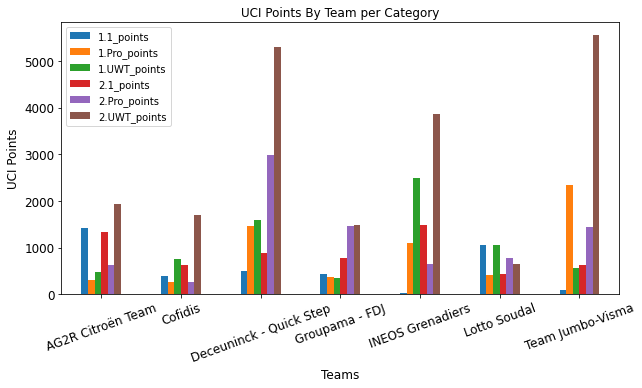

In [17]:
ax = wt_teams_df[find_all_rider_stat_points(list(wt_teams_df.columns))].plot(kind='bar', 
                                                                             title ="UCI Points By Team per Category", 
                                                                             figsize=(10, 5), 
                                                                             legend = True, 
                                                                             fontsize=12)
ax.set_xlabel("Teams", fontsize=12)
ax.set_ylabel("UCI Points", fontsize=12)
ax.set_xticklabels(wt_teams_df["team"])
plt.xticks(rotation=20)
plt.show()

It is interesting to see the breakdown in the overall distribution per team to see where their points are coming from. The three biggest teams by points (Jumbo, Ineos, and Quick Step) get a bulk of the overall points from the 2.UWT race classification. The big 3 and AG2R seem to target specific race types besides 2.UWT. Quick Step is taking the majority of points at the 2.Pro level, Ineos takes the most 1.UWT points, Jumbo takes the most 1.Pro points. AG2R works around these teams. AG2R besides their 2.UWT points gets a bunch of their points for 1.1 and 2.1 races. Ineos and AG2R from a points perspective are getting a similar number of points in 2.1.

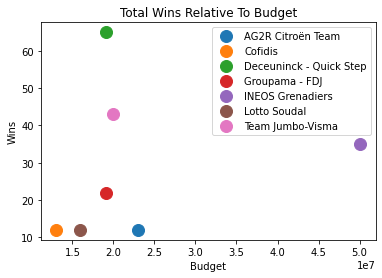

In [32]:
for budget, wins, team in zip(wt_teams_df["scaled_budget"],wt_teams_df["wins"],wt_teams_df["team"]):
    plt.plot(budget, wins, marker='o', linestyle='', markersize=12, label=team)
plt.xlabel("Budget")
plt.ylabel("Wins")
plt.title("Total Wins Relative To Budget")
plt.legend()
plt.show()

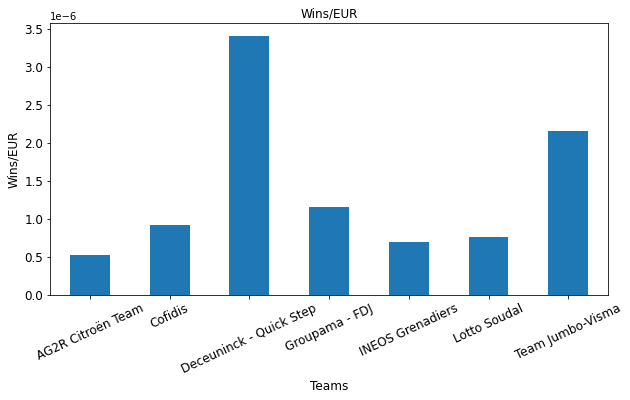

In [33]:
ax = wt_teams_df[["wins/euro"]].plot(kind='bar', title ="Wins/EUR", figsize=(10, 5),fontsize=12)
ax.set_xlabel("Teams", fontsize=12)
ax.set_ylabel("Wins/EUR", fontsize=12)
ax.set_xticklabels(wt_teams_df["team"])
plt.xticks(rotation=25)
ax.get_legend().remove()
plt.show()

Ineos again lags when you look at the number of wins the team gets relative to the budget. AG2R performs well at getting UCI points but does not perofrm well when getting wins. Ineos is again one of the worst performers when it comes to wins/euro. Quick Step is again one of the best performers when looking at both wins and the amount that they spend to get their wins.

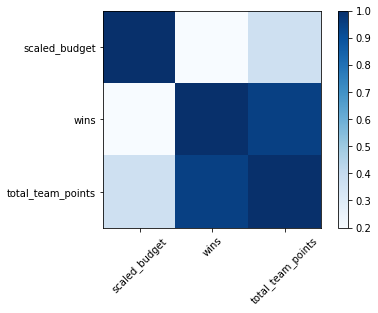

In [56]:
corr_matrix = wt_teams_df[["scaled_budget", "wins", "total_team_points"]].corr()
fig, ax = plt.subplots()
plt.xticks(ticks=np.arange(len(corr_matrix.columns)),labels=corr_matrix.columns,rotation=45)
plt.yticks(ticks=np.arange(len(corr_matrix.columns)),labels=corr_matrix.columns)
im = ax.imshow(corr_matrix, cmap="Blues")
plt.colorbar(im)
plt.show()

The correlation that was calculated is heavily slanted towards Quick Step because of how many points and wins that they generated. We can determine that the relationship between budget and wins or points is not strong. In our small sample we have Jumbo and Quickstep competing on smaller budgets but taking the most number of wins and points. Ineos has the largest budget and a lot of wins but on a per euro basis they are one of the worst performers. 

## Sources:
### Budget:
Ineos/Groupama/Quick Step: https://inrng.com/2021/07/ineos-team-budget-2020/
Lotto: https://inrng.com/2022/01/lotto-soudal-budget-accounts/
AG2R: https://ag2rcitroenteam.com/en/ag2r-citroen-team-through-2025/
Jumbo: https://www.cyclingweekly.com/news/racing/jumbo-vismas-budget-will-increase-e20million-team-chases-grand-tour-success-435107